<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

In [ ]:
# install dependencies:
!pip install pyyaml==5.1
!pip install Pillow==5.3.0
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
!gcc --version

In [ ]:
# Some basic setup:
import torch, torchvision
import torch
assert torch.__version__.startswith("1.7")

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Read Image

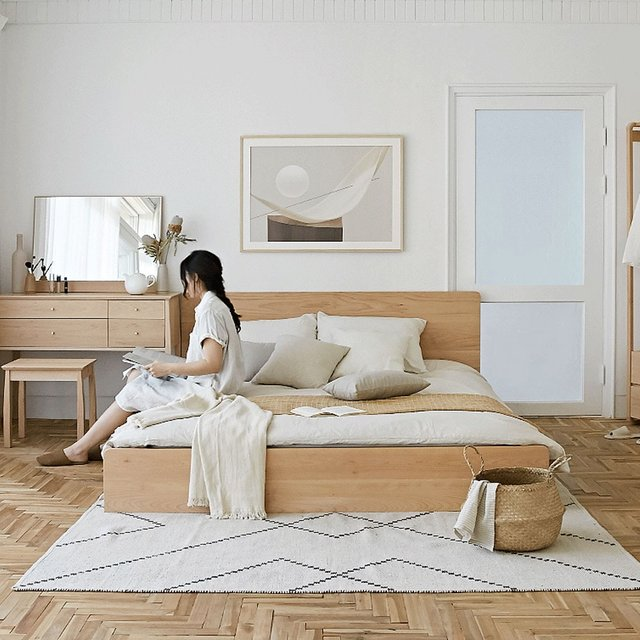

In [3]:
# !wget C:\Code\project\deep learning\datas\bed_55795.png -q -O input.jpg
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/bed_54564.png")
cv2_imshow(im)

# Object Detection

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [5]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 59, 75, 75, 58], device='cuda:0')
Boxes(tensor([[ 38.0373, 249.4327, 247.2323, 465.4586],
        [ 29.6804, 286.7626, 572.2327, 534.1513],
        [156.6927, 262.4166, 168.9392, 292.1446],
        [123.8042, 272.4042, 149.3442, 294.4478],
        [131.2823, 214.6453, 196.6833, 292.9135]], device='cuda:0'))


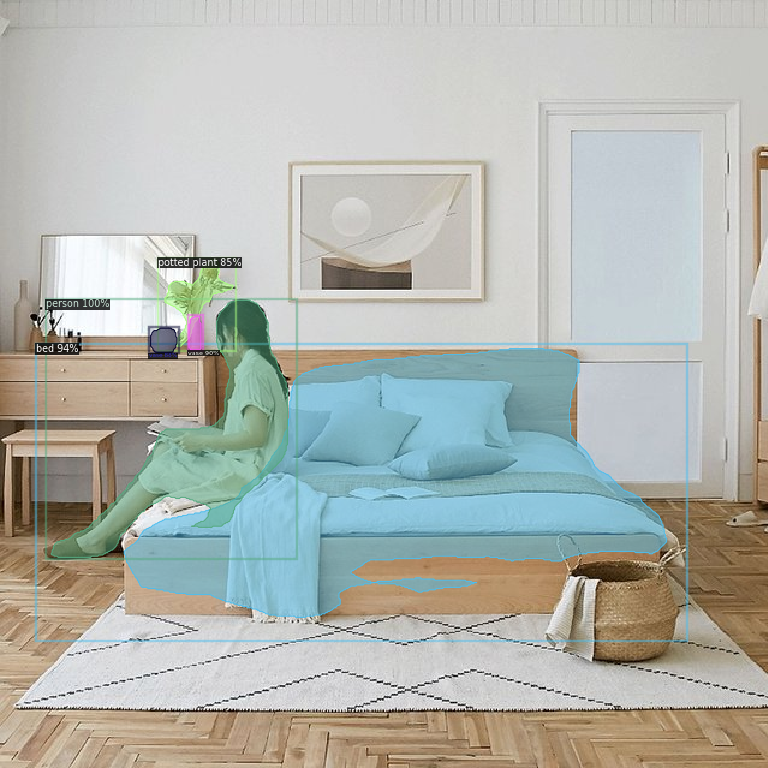

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Write object to image file

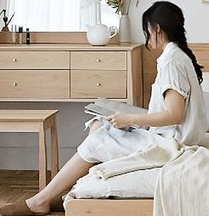

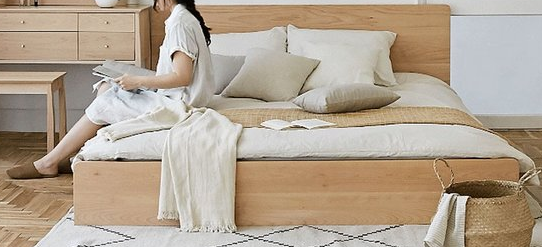

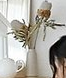

In [7]:
for cls, xy in zip(outputs["instances"].pred_classes, outputs["instances"].pred_boxes):
  xy = list(map(round, xy.tolist()))
  dst = im[xy[1]:xy[3], xy[0]:xy[2]].copy()
  cv2_imshow(dst)
  obj = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[cls]
  cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/datas/{}.png".format(obj), dst)

# Comparing histograms

In [8]:
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import pandas as pd

src_base = cv.imread('/content/drive/MyDrive/Colab Notebooks/datas/bed.png')
src_test1 = cv.imread('/content/drive/MyDrive/Colab Notebooks/datas/bed_54581.png')
src_test2 = cv.imread('/content/drive/MyDrive/Colab Notebooks/datas/bed_85276.png')

if src_base is None or src_test1 is None or src_test2 is None:
    print('Could not open or find the images!')
    exit(0)

hsv_base = cv.cvtColor(src_base, cv.COLOR_BGR2HSV)
hsv_test1 = cv.cvtColor(src_test1, cv.COLOR_BGR2HSV)
hsv_test2 = cv.cvtColor(src_test2, cv.COLOR_BGR2HSV)
hsv_half_down = hsv_base[hsv_base.shape[0]//2:,:]

h_bins = 50
s_bins = 60
histSize = [h_bins, s_bins]

# hue varies from 0 to 179, saturation from 0 to 255
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges # concat lists

# Use the 0-th and 1-st channels
channels = [0, 1]
hist_base = cv.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
hist_half_down = cv.calcHist([hsv_half_down], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_half_down, hist_half_down, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
hist_test1 = cv.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
hist_test2 = cv.calcHist([hsv_test2], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_test2, hist_test2, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

df = []

for compare_method in range(4):
    base_base = cv.compareHist(hist_base, hist_base, compare_method)
    base_half = cv.compareHist(hist_base, hist_half_down, compare_method)
    base_test1 = cv.compareHist(hist_base, hist_test1, compare_method)
    base_test2 = cv.compareHist(hist_base, hist_test2, compare_method)
    df.append({base_base, base_half, base_test1, base_test2})

pd.DataFrame(df, columns = ['Input-Input', 'Input-Half', 'Input-Test1', 'Input-Test2'], index = ['Correlation', 'Chi-square', 'Intersection', 'Bhattacharyya'])

Input-Input  Input-Half  Input-Test1  Input-Test2
Correlation       0.887404    1.000000     0.314612     0.359966
Chi-square        0.000000  603.683317     4.217753    31.825348
Intersection     18.061100    3.426656     5.143728    23.057872
Bhattacharyya     0.000000    0.226739     0.488884     0.564270

# Cannot detect lamp objects

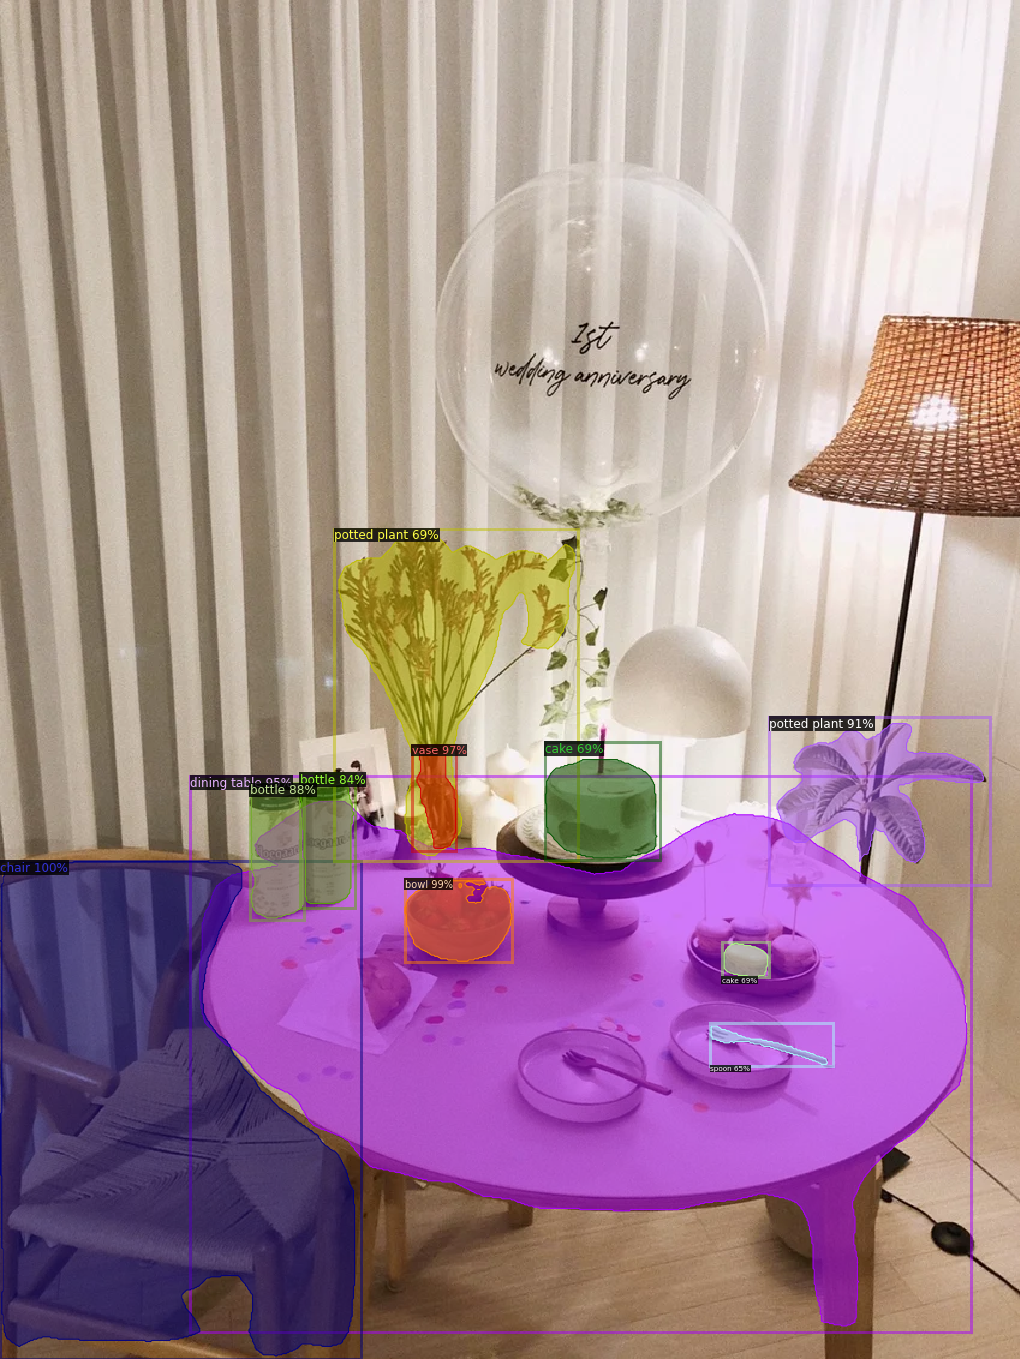

In [9]:
im2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/test_img.jpg")
outputs2 = predictor(im2)
v2 = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out2 = v2.draw_instance_predictions(outputs2["instances"].to("cpu"))
cv2_imshow(out2.get_image()[:, :, ::-1])

# Fine Tuning
 - Labelling more than 1k Lamp images in Roboflow.com

In [ ]:
!curl -L "link" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

## Register dataset

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

## Visualize training data

WARNING [02/07 09:43:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/07 09:43:52 d2.data.datasets.coco]: Loaded 2466 images in COCO format from /content/train/_annotations.coco.json


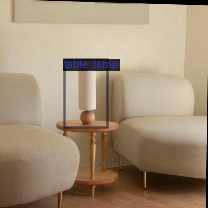

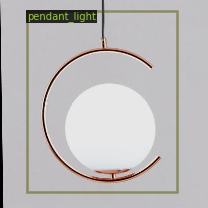

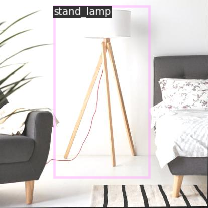

In [11]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train and evaluate our model

In [12]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [13]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/07 09:43:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:15, 27.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[02/07 09:44:20 d2.engine.train_loop]: Starting training from iteration 0
[02/07 09:44:57 d2.utils.events]:  eta: 1:02:00  iter: 19  total_loss: 2.302  loss_cls: 1.448  loss_box_reg: 0.8247  loss_rpn_cls: 0.0238  loss_rpn_loc: 0.0084  time: 1.8742  data_time: 0.0272  lr: 1.9981e-05  max_mem: 7386M
[02/07 09:45:35 d2.utils.events]:  eta: 1:01:49  iter: 39  total_loss: 1.99  loss_cls: 1.155  loss_box_reg: 0.8611  loss_rpn_cls: 0.01901  loss_rpn_loc: 0.008154  time: 1.8779  data_time: 0.0098  lr: 3.9961e-05  max_mem: 7386M
[02/07 09:46:14 d2.utils.events]:  eta: 1:01:43  iter: 59  total_loss: 1.679  loss_cls: 0.8  loss_box_reg: 0.8451  loss_rpn_cls: 0.04004  loss_rpn_loc: 0.01066  time: 1.9024  data_time: 0.0125  lr: 5.9941e-05  max_mem: 7386M
[02/07 09:46:54 d2.utils.events]:  eta: 1:02:25  iter: 79  total_loss: 1.557  loss_cls: 0.697  loss_box_reg: 0.8253  loss_rpn_cls: 0.01058  loss_rpn_loc: 0.007076  time: 1.9385  data_time: 0.0130  lr: 7.9921e-05  max_mem: 7386M
[02/07 09:47:35 d2.ut

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [15]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/07 10:58:38 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
WARNING [02/07 10:58:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/07 10:58:38 d2.data.datasets.coco]: Loaded 118 images in COCO format from /content/test/_annotations.coco.json
[02/07 10:58:38 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |   category    | #instances   |  category  | #instances   |
|:----------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| furniture  | 0            | pendant_light | 41           | stand_lamp | 51           |
| table_lamp | 40           |               |              |            |              |
|   total    | 132          |               |              |            |              |
[02/07 10:58:38 d2.data.dataset_mapper]: [DatasetMapper] Augmen

OrderedDict([('bbox',
              {'AP': 63.39801356755296,
               'AP-furniture': nan,
               'AP-pendant_light': 56.79991803136177,
               'AP-stand_lamp': 68.18090881077971,
               'AP-table_lamp': 65.21321386051739,
               'AP50': 94.54775615733293,
               'AP75': 69.7303874143601,
               'APl': 63.9145700716096,
               'APm': 49.801980198019805,
               'APs': nan})])

In [16]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1612691040.b772c2bbf027.904.0  metrics.json
instances_predictions.pth                          model_final.pth


In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )   
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# It only detects lamps
 - Detect 2 table lamps but one of those is a balloon :(
 - Miss 1 stand lamp
 - Need more work

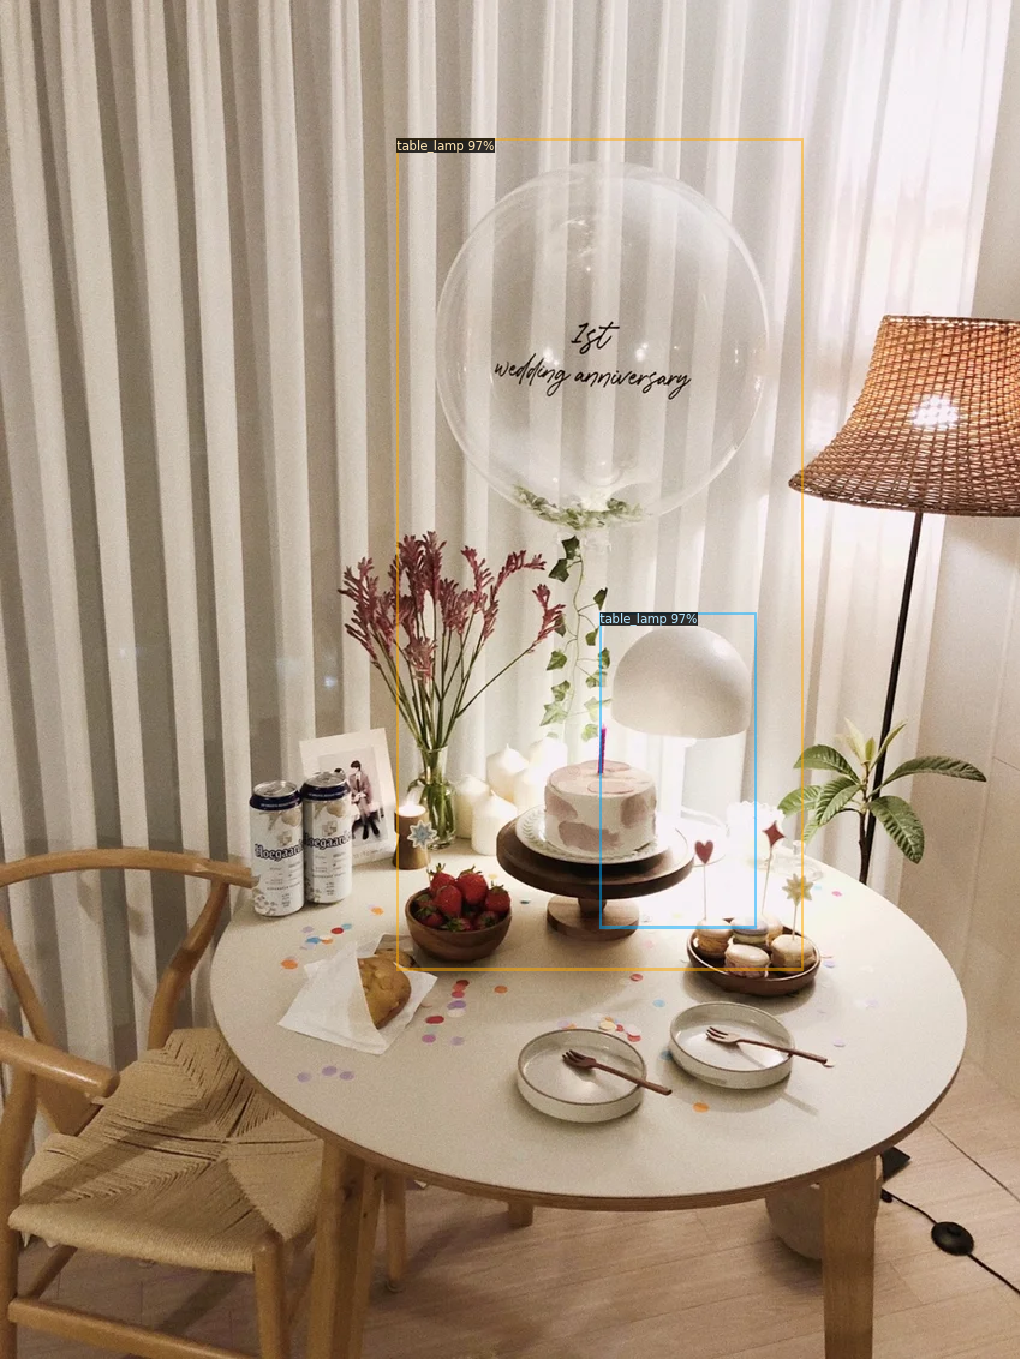

In [19]:
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/test_img.jpg")
outputs = predictor(im)
v = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])